## Table of Content

1. **[Import Libraries](#lib)**
2. **[Data Preparation & Exploratory Data Analysis](#prep)**
    - 2.1 - **[Understand the Data](#read)**
    - 2.2 - **[Analysis of Target variable](#Analysis_Target)**
    - 2.2 - **[Missing Value Analysis and Treatment](#null)**
    - 2.3 - **[Outlier Analysis and Treatment](#outlier)**
        - 2.3.1 **[capping the Outliers](#capping)**
        - 2.3.2 **[KNN-imputation of Outliers](#knn_impute)**
    - 2.4 - **[Pair plot](#pair_plot)**

3. **[Multiple Linear Regression (MLR)](#MLR)**
    - 3.1 - **[Assumptions Before MLR Model](#before_model)**
        - 3.1.2.1 - **[Correlation Matrix](#corr)**
        - 3.1.2.2 - **[Variance Inflation Factor (VIF)](#vif)**
    - 3.2 - **[Build the MLR Model](#full_model)** 
    - 3.3 - **[Assumptions of linear Regression](#after_model)**
4. **[Model Evaluation](#eval)**
    - 4.1 - **[Interval Estimate](#Interval_estimate)**
5. **[Feature selection & Model Evaluation](#Feature_eval)**
6. **[Final MLR model](#final_MLR)**
7. **[Regularization](#Reg)**
    - 7.1 - **[L-1 Regularization](#L1_reg)**
    - 7.2 - **[L-2 Regularization](#L2_reg)**
8. **[Polynomial Linear Regression](#poly_reg)**
    - 8.1 - **[Polynomial L-1 Regularization](#poly_L1_reg)**
    - 8.2 - **[Polynomial L-2 Regularization](#poly_L2_reg)**
9. **[K-Nearest-Neighbour Regression](#knn)**
    - 9.1 - **[KNN hyperparameter tuning](#knn-hyper-tuning)**
10. **[Report](#final)**
11. **[Final Model](#final_model)**

<a id="lib"></a>
### `Importing Liabraries`

In [3]:
import numpy as np
import pandas as pd

from scipy.stats import zscore,iqr
import scipy.stats as stats

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold,RepeatedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from statsmodels.api import add_constant,OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter


from warnings import filterwarnings
filterwarnings(action='ignore')

%matplotlib inline

<a id="prep"></a>
### `Data Preparation`

In [5]:
columns = ['mpg','cylinders','displacement','horsepower','weight',
           'acceleration','model year','origin','car name']
df = pd.read_csv('autos_mpg.csv')

In [8]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [10]:
# Ensure the first column is treated as a string
df.iloc[:, 0] = df.iloc[:, 0].astype(str)

# Split the column by tab character
split_df = df.iloc[:, 0].str.split("\t", expand=True)

# Check if the split operation produced more than one column
if split_df.shape[1] > 1:
    car_name = split_df[1]  # Get the second column
    df = split_df.drop(1, axis=1)[0]  # Drop the second column, keep the first
else:
    # Handle cases where there is no tab (no second column)
    car_name = None
    df = df.iloc[:, 0]  # Or process it differently, e.g., keep the original data


In [12]:
car_name = df.iloc[:,0].str.split("\t",expand=True)[1]
df = df.iloc[:,0].str.split("\t",expand=True).drop(1,axis=1)[0]
df = df.str.split(expand=True)

df[8] = car_name
df.columns = columns
df.columns = [i.replace(" ","_") for i in df.columns]

IndexingError: Too many indexers

In [14]:
# Convert the first column to string type to avoid the error
df.iloc[:, 0] = df.iloc[:, 0].astype(str)

# Now split the values by tab character and access the parts
car_name = df.iloc[:, 0].str.split("\t", expand=True)[1]
df = df.iloc[:, 0].str.split("\t", expand=True).drop(1, axis=1)[0]


IndexingError: Too many indexers

In [16]:
df.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: object

<a id="read"></a>
### `Data understanding`

### cylinders

- The cylinder is the power unit of the engine. This is where fuel is burned and converted into mechanical energy that powers the vehicle. The number of cylinders in a typical car could be four, six or eight.

**https://www.arnoldclark.com/newsroom/2331-everything-you-need-to-know-about-engine-cylinders**

### Displacement
- Engines displace air by means of a crankshaft-driven piston. It draws air in on the intake stroke and pushes it out on the exhaust stroke.

**https://www.thedrive.com/cars-101/40767/what-is-engine-displacement**

<img src="1.png" width="350" height="300" alignment='left'/>

### Horsepower

- It's calculated through the power needed to move 550 pounds one foot in one second or by the power needs to move 33,000 pounds one foot in one minute

### weight

- weight of the car in pounds

### Acceleration

- Time in seconds required to attain a speed of 60mph from 0mph

In [18]:
# The car which has highest acceleration (less time to attain 60mph)

df.loc[df['acceleration'] == df['acceleration'].min()]

KeyError: 'acceleration'

In [35]:
# The car which has highest acceleration (more time to attain 60mph)

df.loc[df['acceleration'] == df['acceleration'].max()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
299,27.2,4,141.0,71,3190,24.8,79,2,peugeot 504


### Model year

- Year in which car hit the Road for the first time ranging from 1970-1982

### Car name

- Name of the car (string)

In [41]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

In [43]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

- since pandas by default taking 'object' datatype
- checking for null values 'NA','?'

In [46]:
null = pd.Series({i:(df[i].isin(['NA','?','NAN','NaN']).sum()) for i in df.columns})
null

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

- mpg & horsepower are having 8 and 6 null values respectively which are represented by 'NA'

In [49]:
df.duplicated().sum()

0

- No duplicate rows are present

In [52]:
df.nunique()

mpg             129
cylinders         5
displacement     82
horsepower       94
weight          351
acceleration     95
model_year       13
origin            3
car_name        305
dtype: int64

In [54]:
numeric = ['mpg','displacement','horsepower','weight','acceleration']
categorical = list(set(df.columns.to_list()).symmetric_difference(numeric))

In [56]:
print("Numerical attributes",end='\n')
print("-"*70)
print(numeric)
print("_"*70)
print(""*70)
print("Categorical attributes")
print("-"*70)
print(categorical)

Numerical attributes
----------------------------------------------------------------------
['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
______________________________________________________________________

Categorical attributes
----------------------------------------------------------------------
['car_name', 'model_year', 'cylinders', 'origin']


In [58]:
for col in numeric:
    df[col] = pd.to_numeric(df[col],errors='coerce')

In [60]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

In [62]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


<a id="Analysis_Target"></a>
### `Analysis of Target variable`

- Target is fuel efficiency of cars i.e **mpg (miles per gallon of fuel)**

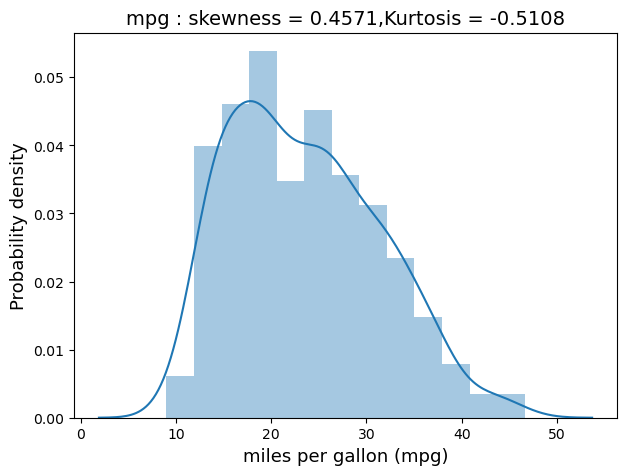

In [66]:
plt.figure(figsize=(7,5))
sns.distplot(df['mpg'])
plt.title(f"mpg : skewness = {df['mpg'].skew():0.4f},Kurtosis = {df['mpg'].kurt():0.4f}",
         fontsize= 14)
plt.ylabel("Probability density",fontsize=13)
plt.xlabel("miles per gallon (mpg)",fontsize=13)
plt.show()

- Target is slightly right skewed distribution

In [69]:
# The car which has maximum fuel efficiency 'miles per gallon'

df[df['mpg'] == df['mpg'].max()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
322,46.6,4,86.0,65.0,2110,17.9,80,3,mazda glc


In [71]:
# The car which has minimum fuel efficinecy 'miles per gallon'

df[df['mpg'] == df['mpg'].min()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
28,9.0,8,304.0,193.0,4732,18.5,70,1,hi 1200d


In [312]:
# Strip trailing periods first
df['origin'] = df['origin'].str.rstrip('.')

# Try to convert to numeric (coercing errors to NaN)
df['origin'] = pd.to_numeric(df['origin'], errors='coerce')

# Optional: Fill NaN values with a default (e.g., 0) or drop them
df['origin'] = df['origin'].fillna(0).astype(np.int32)  # Replace NaN with 0
# or
# df['origin'] = df['origin'].dropna().astype(np.int32)  # Drop NaN values


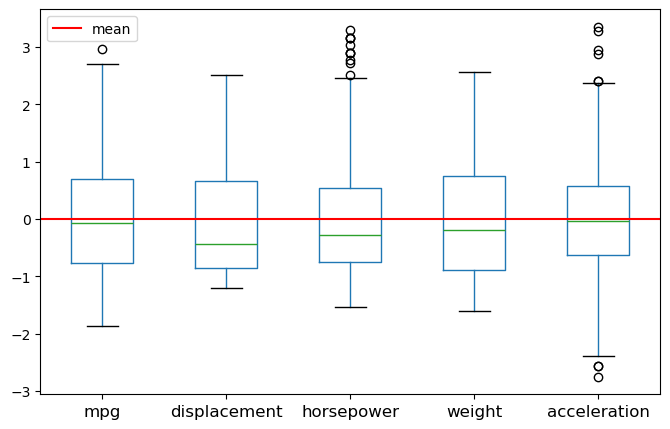

In [314]:
plt.figure(figsize=(8,5))
df.loc[:,['mpg','displacement','horsepower','weight','acceleration']].apply(zscore).boxplot()
plt.axhline(color='red',label='mean')
plt.xticks(fontsize=12)
plt.legend()
plt.grid()
plt.show()

- Due to null values the columns are not showing the values

<a id="null"></a>
### `1) Null value treatment`

- Let us check before Null value Imputation,after null value imputation by plotting distribution
- We will come to know how Median imputation will change the Distribution

- we have null values in 
  - mpg
  - horsepower
- Since we have not checked outliers & null values are less than 2 percent
- let us impute null values using median
- and check how distribution will change

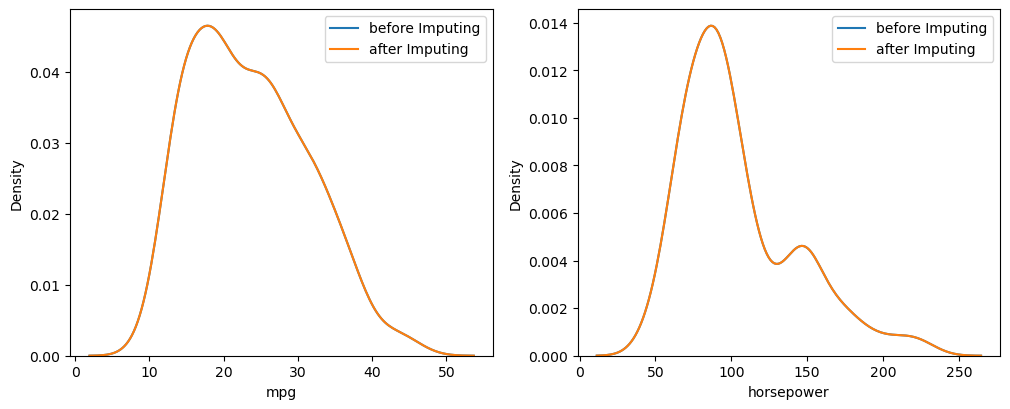

In [320]:
fig,ax = plt.subplots(1,2,figsize=(12,4.5))
for i,col in enumerate(['mpg','horsepower']):
    sns.kdeplot(df[col],ax=ax[i],label='before Imputing')
    df[col] = df[col].fillna(df[col].median())
    sns.kdeplot(df[col],ax=ax[i],label='after Imputing')
    ax[i].legend()
plt.show()

- Above plot shows that median imputation did not distort our original distribution, so we will proceed further

<a id="outlier"></a>
### `2) Outlier Analysis`

In [324]:
df.select_dtypes(np.number).skew()

mpg             0.457066
cylinders       0.526922
displacement    0.719645
horsepower      1.106224
weight          0.531063
acceleration    0.278777
model_year      0.011535
origin          0.000000
dtype: float64

In [326]:
df.select_dtypes(np.number).kurt()

mpg            -0.510781
cylinders      -1.376662
displacement   -0.746597
horsepower      0.763583
weight         -0.785529
acceleration    0.419497
model_year     -1.181232
origin          0.000000
dtype: float64

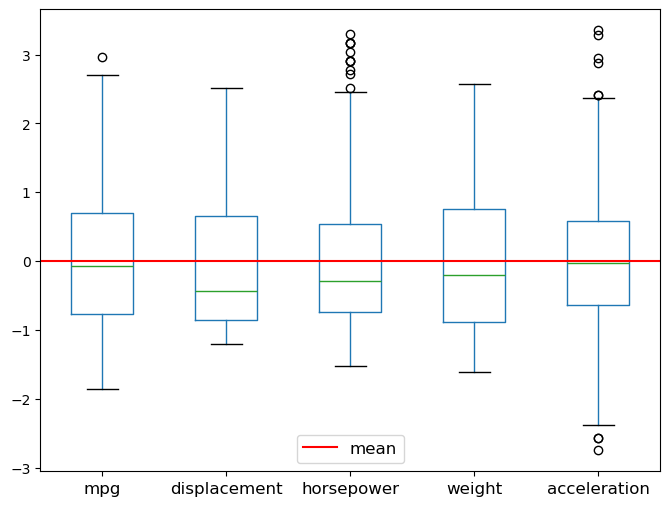

In [328]:
plt.figure(figsize=(8,6))
df.loc[:,['mpg','displacement','horsepower','weight','acceleration']].apply(zscore).boxplot()
plt.axhline(color='red',label='mean')
plt.xticks(fontsize=12)
plt.legend(loc='lower center',fontsize=12)
plt.grid()
plt.show()

#### We have outliers in 
- 1) Mpg
- 2) Horse power
- 3) Acceleration

- We can also remove them if we have good amount of data & outliers are few
- As we have are having small data we will try different techniques
  - Capping (Replacing with end of the distribution values)
  - taking outliers as null values and imputing them

#### IQR - Inter Quartile Range

- Upper limit = Q1 - 1.5*IQR
- Lower limit = Q3 + 1.5*IQR

In [334]:
for feature in ['mpg','horsepower','acceleration','weight']:
    lower_limit = np.quantile(df[feature],0.25) - 1.5*iqr(df[feature])
    upper_limit = np.quantile(df[feature],0.75) + 1.5*iqr(df[feature])
    print(f"{feature} : lower_limit = {lower_limit}, upper_limit = {upper_limit}")

mpg : lower_limit = 0.25, upper_limit = 46.25
horsepower : lower_limit = 2.5, upper_limit = 198.5
acceleration : lower_limit = 8.8, upper_limit = 22.2
weight : lower_limit = 147.375, upper_limit = 5684.375


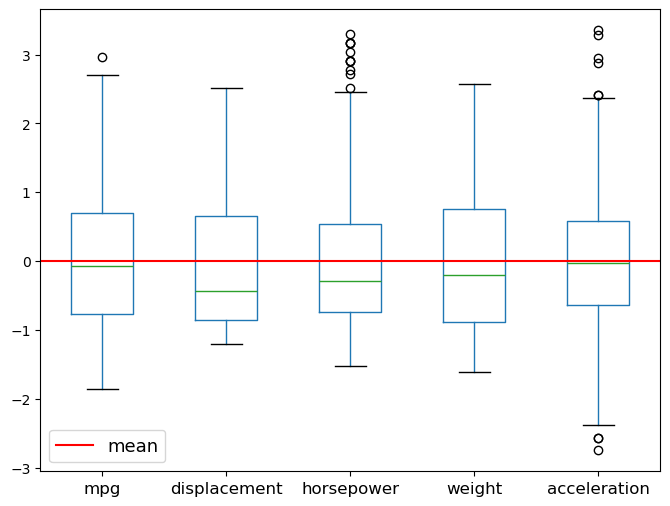

In [336]:
plt.figure(figsize=(8,6))
df.loc[:,['mpg','displacement','horsepower','weight','acceleration']].apply(zscore).boxplot()
plt.axhline(color='red',label='mean')
plt.xticks(fontsize=12)
plt.legend(loc='lower left',fontsize=13)
plt.grid()
plt.show()

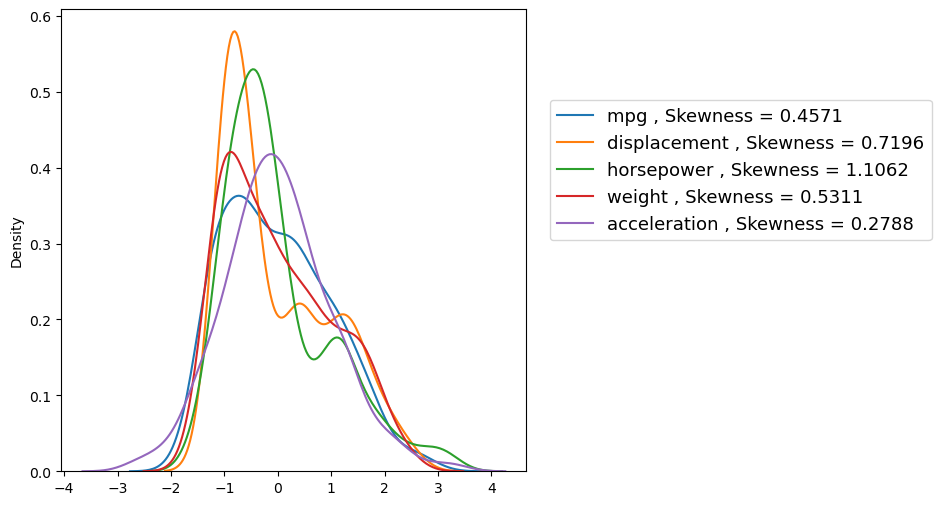

In [338]:
fig,ax = plt.subplots(figsize=(6,6))
for column in ['mpg','displacement','horsepower','weight','acceleration']:
    sns.kdeplot(df[[column]].apply(zscore).to_numpy().flatten(),
                label=f"{column} , Skewness = {df[column].skew():0.4f}")
plt.legend(fontsize=13,loc=(1.05,0.5))
plt.show()

<a id="capping"></a>
### `Capping`

In [341]:
# Function for capping outliers

def capping(dataframe,feature,threshold=1.5): 
    """ capping refers to replacing outliers with the
    end of the distribution values"""
    upper_limit = np.quantile(dataframe[feature],0.25) + threshold*iqr(dataframe[feature])
    lower_limit = np.quantile(dataframe[feature],0.75) - threshold*iqr(dataframe[feature])
    capp = np.where(dataframe[feature] <= lower_limit,lower_limit,
                    np.where(dataframe[feature] >= upper_limit,upper_limit,dataframe[feature]))
    return capp

### Lets confirm & visualize wheather the capping has yielded good results

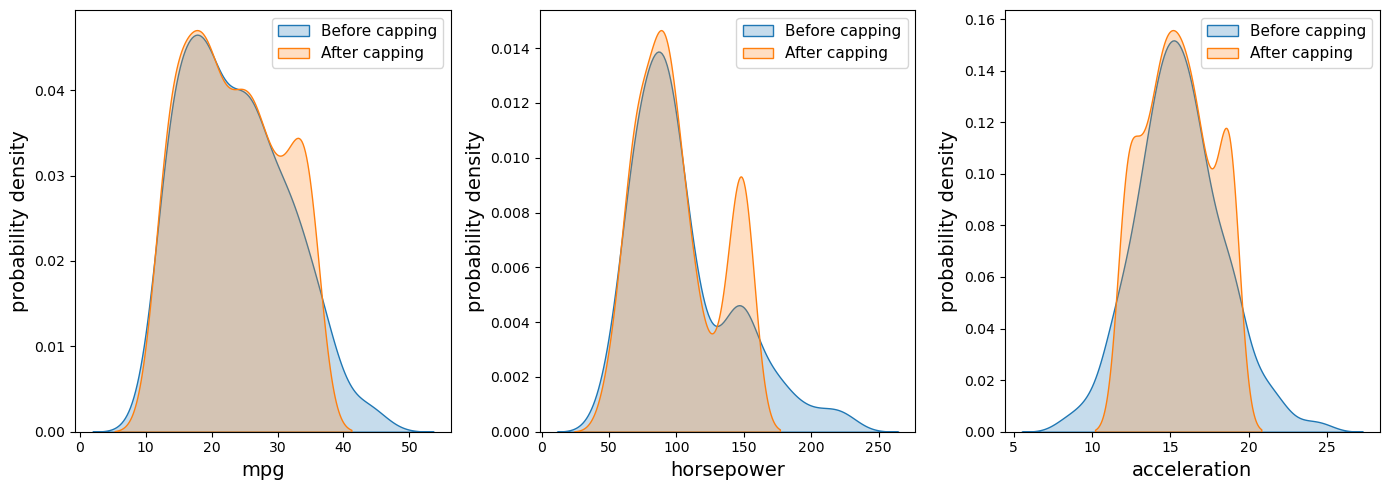

In [344]:
fig,axs = plt.subplots(1,3,figsize=(14,5))
for subplot,col in zip(axs.flatten(),['mpg','horsepower','acceleration']):
    sns.kdeplot(df[col],label='Before capping',ax=subplot,fill=True)
    # applying functions for capping
    cap = capping(df,col)
    sns.kdeplot(cap,label='After capping',ax=subplot,fill=True)
    subplot.set_xlabel(f"{col}",fontsize=14)
    subplot.set_ylabel(f"probability density",fontsize=14)
    subplot.legend(fontsize=11) 
plt.tight_layout()
plt.show()

- capping has resulted in distorting distribution to much extent

<a id="knn_imputation"></a>
### `KNN-imputation`

#### Let us try to make outliers as null values and impute them through KNN-imputer

In [349]:
# Function to look at outliers based on IQR and Z_score
# storing all the indexes of outliers in dictionary with their corresponding columns

def outliers(dataframe,feature,criteria ='IQR',threshold = 1.5):
    """criteria={'IQR','zscore'} default IQR"""
    if criteria in ['IQR','Iqr','iqr']:
        upper_limit = np.quantile(dataframe[feature],0.75) + threshold*iqr(dataframe[feature])
        lower_limit = np.quantile(dataframe[feature],0.25) - threshold*iqr(dataframe[feature])
        dframe = dataframe[(dataframe[feature] < lower_limit) | (dataframe[feature] > upper_limit)]
        return dframe.index
    elif criteria in ['zscore','Zscore','z-score','Z-score','Z']:
        df_z = ((dataframe[feature] - dataframe[feature].mean())/dataframe[feature].std())
        return df[(df_z < (-1*threshold)) | (df_z > threshold)].index
    else:
        return "Mention correct criteria"

- lets look at the indexes of outliers in different columns
- and let's consider the technique of zscore & threshold as 1.5 standard deviations

In [352]:
outlier_index = dict()
for column in ['mpg','horsepower','acceleration','weight']:
    outlier_index[column] = outliers(df,column,criteria='zscore',threshold=1.75)
outlier_index

{'mpg': Index([ 28, 244, 247, 304, 309, 310, 312, 322, 324, 325, 326, 329, 330, 343,
        344, 348, 378, 383, 385, 387, 394],
       dtype='int64'),
 'horsepower': Index([  5,   6,   7,   8,   9,  13,  25,  26,  27,  28,  39,  42,  44,  63,
         67,  70,  85,  90,  94,  95,  96, 106, 116, 124, 212, 229, 231],
       dtype='int64'),
 'acceleration': Index([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  19,  56,  59, 102,
        116, 131, 154, 160, 195, 196, 200, 209, 244, 299, 300, 325, 326, 328,
        352, 359, 374, 394],
       dtype='int64'),
 'weight': Index([ 25,  28,  39,  42,  43,  44,  67,  68,  69,  90,  91,  94,  95, 103,
        104, 105, 106, 137, 138, 139, 156, 158, 159],
       dtype='int64')}

- Total outliers based on above criteria

In [355]:
indexing = set()
for i in outlier_index:
    for j in outlier_index[i]:
        indexing.add(j)
print("Total outliers :",len(indexing))

Total outliers : 81


In [357]:
Imputation_df = df.copy()

- let us set outliers as null values and try to impute them with KNN-imputer

In [360]:
for feature in ['mpg','horsepower','acceleration']:
    Imputation_df.loc[outlier_index[feature],feature] = np.nan

In [362]:
Imputation_df.isnull().sum()

mpg             21
cylinders        0
displacement     0
horsepower      27
weight           0
acceleration    32
model_year       0
origin           0
dtype: int64

In [364]:
numeric = Imputation_df.select_dtypes(np.number)
Imputer = KNNImputer()
final_imputation = Imputer.fit_transform(numeric)
knn_imputation = pd.DataFrame(final_imputation,columns=numeric.columns)

- let us check how z-score based outliers are imputed

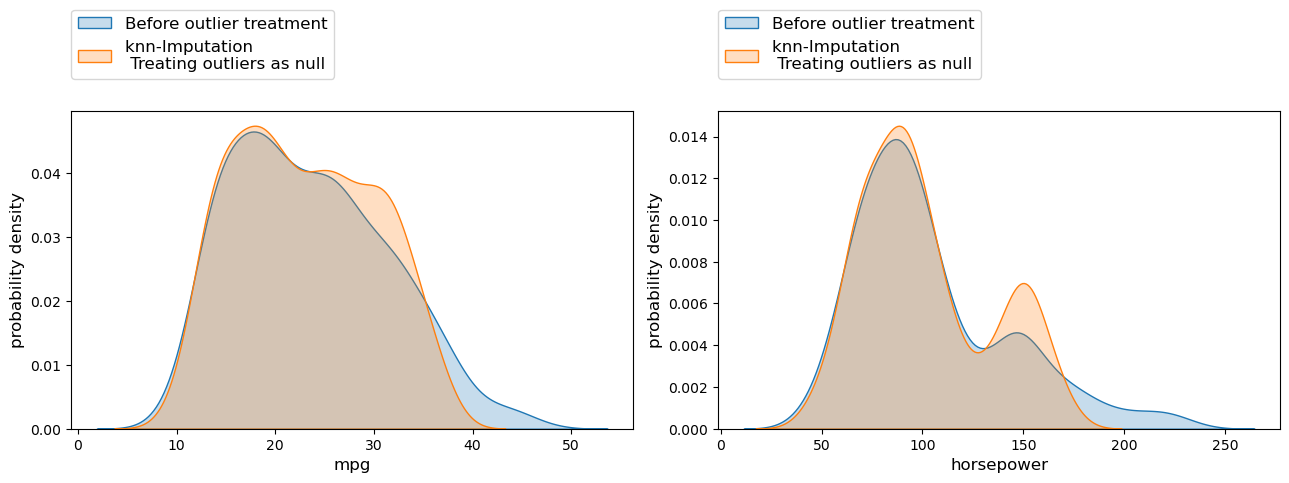

In [367]:
fig,axs = plt.subplots(1,2,figsize=(13,5))
for subplot,col in zip(axs.flatten(),['mpg','horsepower','acceleration']):
    sns.kdeplot(df[col],label='Before outlier treatment',ax=subplot,fill=True)
    sns.kdeplot(knn_imputation[col],label='knn-Imputation \n Treating outliers as null',
                ax=subplot,fill=True)
    subplot.set_xlabel(f"{col}",fontsize=12)
    subplot.set_ylabel(f"probability density",fontsize=12)
    subplot.legend(loc=(0,1.1),fontsize=12)
plt.tight_layout()
plt.show()

### `KNN-imputer has performed better than Capping`

- we have preserved our distribution, while treating outlier through KNN-imputing
- It has resulted in bias-free,algorithm treated distribution
- let us plot a box-plot to see distribution of data

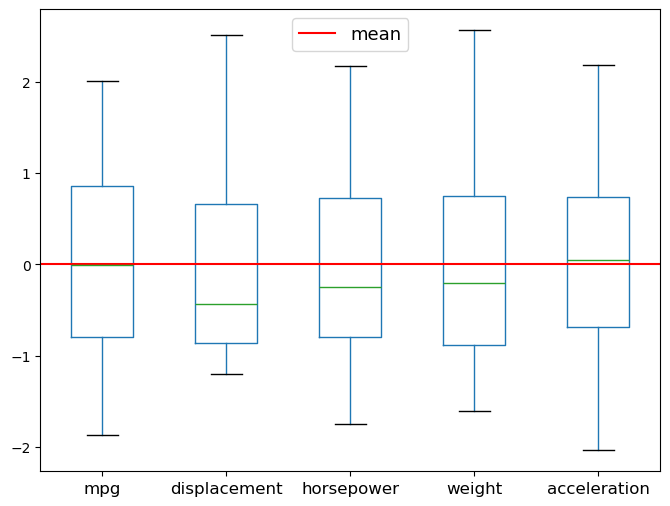

In [371]:
plt.figure(figsize=(8,6))
knn_imputation.loc[:,['mpg','displacement','horsepower','weight','acceleration']].apply(zscore).boxplot()
plt.axhline(color='red',label='mean')
plt.xticks(fontsize=12)
plt.legend(loc='upper center',fontsize=13)
plt.grid()
plt.show()

In [373]:
# Equating imputed dataframe to old dataframe to make changes in outliers

df.select_dtypes(np.number).iloc[:,:] = knn_imputation.iloc[:,:]

In [375]:
df.select_dtypes(np.number).skew()

mpg             0.457066
cylinders       0.526922
displacement    0.719645
horsepower      1.106224
weight          0.531063
acceleration    0.278777
model_year      0.011535
origin          0.000000
dtype: float64

- The skewness of attributes are in acceptable range

<a id='Target'></a>
### `Analysis of Target with other dimensions`

### mpg variation with number of cylinders

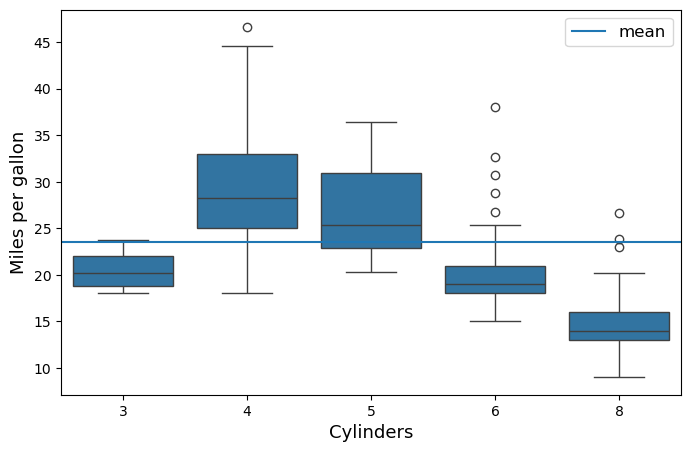

In [380]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df,x='cylinders',y='mpg')
plt.xlabel("Cylinders",fontsize=13)
plt.ylabel("Miles per gallon",fontsize=13)
plt.axhline(df['mpg'].mean(),label='mean')
plt.legend(fontsize=12)
plt.show()

- from above distribution for cylinder 4,5 significant efficiency is achieved
- for some cars with 6 cylinders also significant efficiency is achieved

### Variation of mpg with origin

In [384]:
df['origin'] = df['origin'].str.rstrip('.').astype(np.int32)

AttributeError: Can only use .str accessor with string values!

In [151]:
# Encoding the 'origin' feature with region

df['origin'] = df['origin'].map({1.0:'USA',2.0:'Europe',3.0:'Asia'})

ValueError: List of boxplot statistics and `positions` values must have same the length

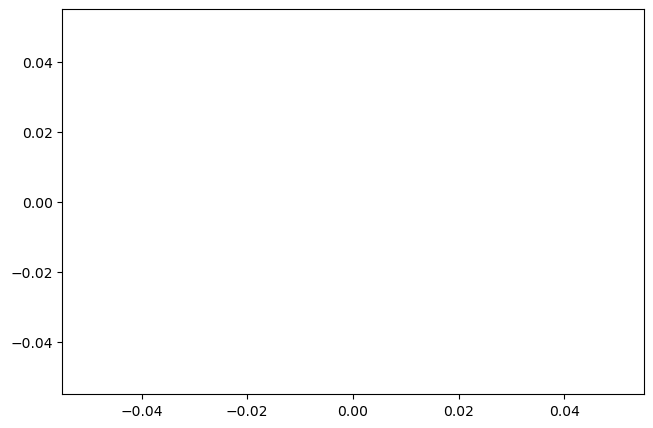

In [153]:
plt.figure(figsize=(7.5,5))
sns.boxplot(data=df,x='origin',y='mpg')
plt.xticks(fontsize=12)
plt.xlabel("Origin",fontsize=13)
plt.ylabel("Miles per gallon",fontsize=13)
plt.axhline(df['mpg'].mean(),color='blue',ls='--',label='mean')
plt.legend(fontsize=12)
plt.show()

- from above distribution we can infer that 
  - most of the cars from USA are having below average efficiency
  - Europe being more than average 
  - while maximum Japanese cars have high efficiency
- this might be due to
  - Factors like bad roads,weather,geographical factors
  - Different efficiency norms due to variation in fuel prices

### variation of mpg with model_year

In [ ]:
df['model_year'] = df['model_year'].map('19{}'.format).str.rstrip(".")

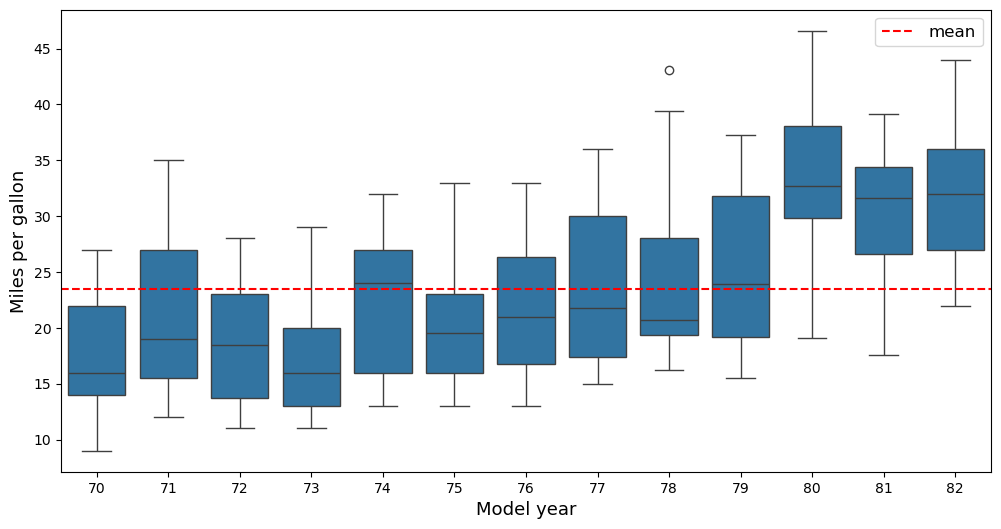

In [156]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df,x='model_year',y='mpg')
plt.xlabel("Model year",fontsize=13)
plt.ylabel("Miles per gallon",fontsize=13)
plt.axhline(df['mpg'].mean(),ls='--',color='red',label='mean')
plt.legend(fontsize=12)
plt.show()

### variation of horsepower with number of cylinders

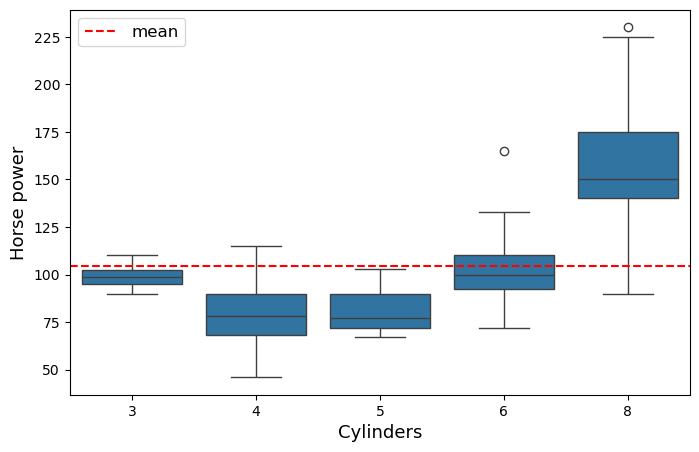

In [159]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df,x='cylinders',y='horsepower')
plt.xlabel("Cylinders",fontsize=13)
plt.ylabel("Horse power",fontsize=13)
plt.axhline(df['horsepower'].mean(),ls='--',color='red',label='mean')
plt.legend(fontsize=12)
plt.show()

### variation of displacement with number of cylinders

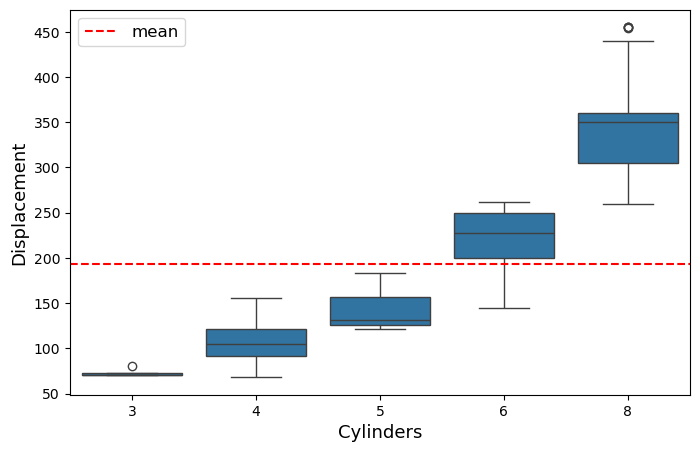

In [162]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df,x='cylinders',y='displacement')
plt.xlabel("Cylinders",fontsize=13)
plt.ylabel("Displacement",fontsize=13)
plt.axhline(df['displacement'].mean(),ls='--',color='red',label='mean')
plt.legend(fontsize=12)
plt.show()

from above distribution we can say that as the innovation has increased
- we saw increase in fuel efficiency

### variation of displacement with number of cylinders

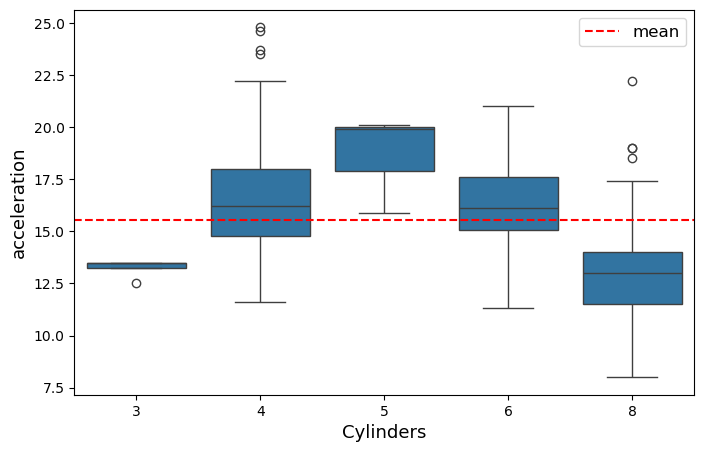

In [166]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df,x='cylinders',y='acceleration')
plt.xlabel("Cylinders",fontsize=13)
plt.ylabel("acceleration",fontsize=13)
plt.axhline(df['acceleration'].mean(),ls='--',color='red',label='mean')
plt.legend(fontsize=12)
plt.show()

### mpg variation with number of origin

ValueError: The following variable cannot be assigned with wide-form data: `hue`

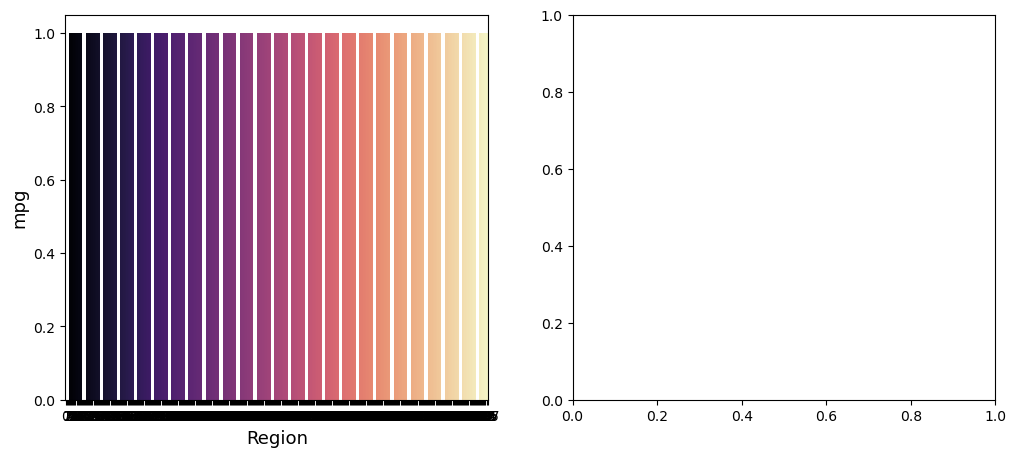

In [169]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.countplot(df['origin'],palette='magma',ax=ax[0])
ax[0].set_xlabel("Region",fontsize=13)
ax[0].set_ylabel("mpg",fontsize=13)
sns.countplot(df['cylinders'],hue=df['origin'],palette='magma',ax=ax[1])
ax[1].set_xlabel("Region",fontsize=13)
ax[1].set_ylabel("mpg",fontsize=13)
plt.show()

- USA has a highest number of cars compared to Europe and Japan

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.countplot(df['origin'],palette='magma',ax=ax[0])
ax[0].set_xlabel("Origin",fontsize=13)
ax[0].set_ylabel("Count",fontsize=13)
sns.countplot(df['cylinders'],hue=df['origin'],palette='magma',ax=ax[1])
ax[1].set_xlabel("Region",fontsize=13)
ax[1].set_ylabel("Count",fontsize=13)
plt.show()

<a id='pair_plot'></a>
## `Pairwise analysis of Data`
- 1) To observe distribution 
- 2) To see pairwise relation 
- 3) To see relation of every features with target

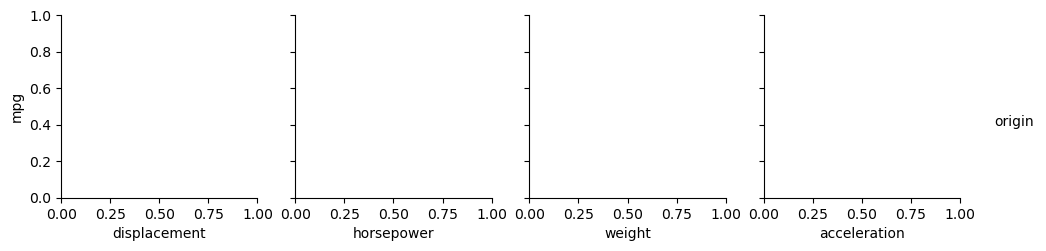

In [309]:
sns.pairplot(data=df,x_vars=['displacement', 'horsepower', 'weight','acceleration'],
             y_vars='mpg',diag_kind='kde',hue='origin')
plt.show()

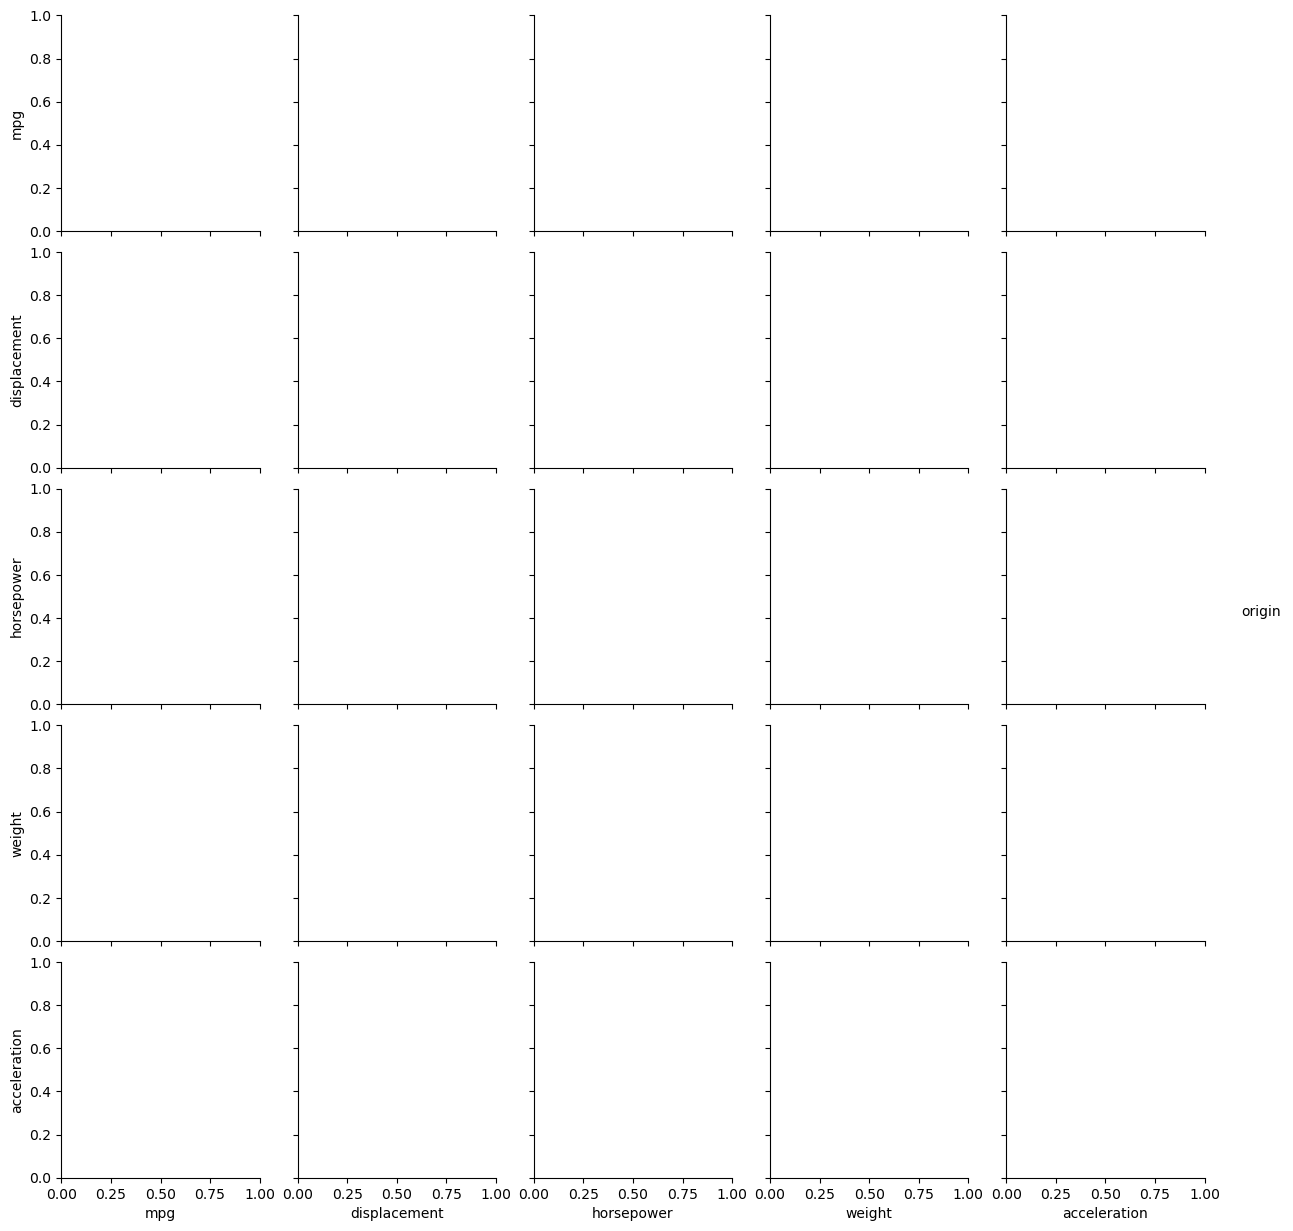

In [308]:
sns.pairplot(data=df[['mpg','displacement','horsepower','weight','acceleration','origin']],
             diag_kind='kde',hue='origin')
plt.show()

In [176]:
data_preprocess = df.copy()

In [177]:
%store data_preprocess

Stored 'data_preprocess' (DataFrame)


### `Functions for reporting`

In [179]:
report_list = ['Model_name','Train_R2','Test_R2','CV_R2_score','Train_RMSE','Test_RMSE',
               'CV_RMSE','Train_MAE','Test_MAE','Train_MAPE','Test_MAPE']

In [180]:
Model_reports = pd.DataFrame(columns=report_list)

In [181]:
Model_reports

,Model_name,Train_R2,Test_R2,CV_R2_score,Train_RMSE,Test_RMSE,CV_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE


In [182]:
# Function for reporting purpose

def report(model,X_train,X_test,y_train,y_test):
    p_model = str(model.__class__()).strip("()")
    print(f"** {p_model} Evaluation & Report **")
    r2_flag = 0
    if any([True if i in p_model else False for i in ['Poly','Linear','Lasso','Ridge']]):
        train_r2_score = r2_score(y_train,model.predict(X_train))
        test_r2_score = r2_score(y_test,model.predict(X_test))
        print("-"*50)
        print("R2 and Adjusted R2 score")
        print("-"*50)
        def adjusted_r2_score(r2_score,size):
            """ size = (n_samples,n_features) """
            adj_r2 = (1-((1-r2_score)*(size[0] - 1))/((size[0] - size[1] - 1)))
            return adj_r2
        print(f"Train R2 score = {train_r2_score*100:0.2f} % mpg explained")
        print(f"Adjusted R2 score = {adjusted_r2_score(train_r2_score,X_train.shape)*100:0.2f} % mpg explained")
        print(f"Test R2 score {test_r2_score*100:0.2f} % mpg explained")
        r2_flag=1
    
    train_rmse = mean_squared_error(y_train,model.predict(X_train),squared=False)
    test_rmse = mean_squared_error(y_test,model.predict(X_test),squared=False)
    
    print("-"*50)
    print("Root mean squared Error")
    print("-"*50)
    print(f"Train RMSE = {train_rmse:0.4f} mpg")
    print(f"Test RMSE = {test_rmse:0.4f} mpg")
    print(f"Variance = {(test_rmse-train_rmse):0.4f} mpg")
    print("-"*50)
    cv_rmse = KFold(n_splits=5,shuffle=True,random_state=45)
    cv_r2 = KFold(n_splits=5,shuffle=True,random_state=45)
    cv_rmse_score = cross_val_score(model,X_train,y_train,cv=cv_rmse,
                                    scoring='neg_root_mean_squared_error').mean()*-1
    print(f"Cross validation RMSE : {cv_rmse_score:0.4f} mpg")
    print("-"*50)
    if any([True if i in p_model else False for i in ['Poly','Linear','Lasso','Ridge']]):
        cv_r2_score = cross_val_score(model,X_train,y_train,cv=cv_r2).mean()
        print("-"*50)
        print(f"Cross validation R2_score : {cv_r2_score*100:0.2f} % ")
        print("-"*50)
    train_mae = mean_absolute_error(y_train,model.predict(X_train))
    test_mae = mean_absolute_error(y_test,model.predict(X_test))                         
    print("Mean Absolute Error")
    print("-"*50)
    print(f"Train MAE = {train_mae:0.4f} mpg")
    print(f"Test MAE = {test_mae:0.4f} mpg")
    print(f"Variance = {(test_mae-train_mae):0.4f} mpg")
                                   
    train_mape = mean_absolute_percentage_error(y_train,model.predict(X_train))
    test_mape = mean_absolute_percentage_error(y_test,model.predict(X_test))
                                   
    print("-"*50)
    print("Mean Absolute Percentage Error")
    print("-"*50)
    print(f"Train MAPE = {train_mape*100:0.2f} % ")
    print(f"Test MAPE = {test_mape*100:0.2f} % ")
    print(f"Variance = {(test_mape-train_mape)*100:0.2f} %") 
    
    report_dict_2 = {'Model_name': p_model,'Train_R2' : np.nan,'Test_R2' : np.nan,
                     'CV_R2_score': np.nan,'Train_RMSE': round(train_rmse,4),
                     'Test_RMSE': round(test_rmse,4),'CV_RMSE': round(cv_rmse_score,4),
                     'Train_MAE' : round(train_mae,4),'Test_MAE': round(test_mae,4),
                     'Train_MAPE': str(round(train_mape*100,2))+ '%',
                     'Test_MAPE': str(round(test_mape*100,2))+ "%"}
    global Model_reports
    if r2_flag == 1:
        report_dict_1 = {'Model_name': p_model,'Train_R2' : str(round(train_r2_score*100,2))+ '%',
                         'Test_R2' : str(round(test_r2_score*100,2))+ '%','CV_R2_score': str(round(cv_r2_score*100,2)) ,
                         'Train_RMSE': round(train_rmse,4),'Test_RMSE': round(test_rmse,4),
                         'CV_RMSE': round(cv_rmse_score,4),'Train_MAE' : round(train_mae,4),
                         'Test_MAE': round(test_mae,4),'Train_MAPE': str(round(train_mape*100,2))+ '%',
                         'Test_MAPE': str(round(test_mape*100,2))+ "%"}
        Model_reports = Model_reports.append(pd.Series(report_dict_1),ignore_index=True)
    if r2_flag == 0:
        Model_reports = Model_reports.append(pd.Series(report_dict_2),ignore_index=True)
    Model_reports = Model_reports.drop_duplicates()

In [190]:
def linear_model(model,df,droplist=None,testsize=0.20,random_state=42):
    flag = 0
    categoty = ['cylinders','model_year','origin']
    numerical = ['displacement','horsepower','acceleration','weight']
    if droplist!=None:
        for i in droplist:
            if i in categoty:
                categoty.remove(i)
                flag = 1
            elif i in numerical:
                numerical.remove(i)
                flag = 1
            else:
                flag = 1
                continue
    if (flag==0)or (flag==1):    
        if len(categoty) == 0:
            df_numeric = df[numerical]
            X = df_numeric
            y = df[['mpg']]

        elif len(numerical) == 0:
            df_categorical = pd.get_dummies(df[categoty].astype(str),drop_first=True)
            X = df_categorical
            y = df[['mpg']]
        else:
            df_categorical = pd.get_dummies(df[categoty].astype(str),drop_first=True)
            df_numeric = df[numerical]
            X = pd.concat([df_numeric,df_categorical],axis=1)
            y = df[['mpg']]
        linear_reg = model
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testsize, 
                                                            random_state=random_state)
        linear_reg.fit(X_train,y_train)
        return report(linear_reg,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

<a id='MLR'></a>
# `Linear Regression`

<a id='before_model'></a>
### `Assumptions before model`

### 1) Target should be continuous
### 2) No or Little Multicollinearity

- Let's build a model with full predictors & check for assumptions
- Let us drop the 'Car_name' feature as it does not provide much information 

In [196]:
df = df.drop('car_name',axis=1)
df_upto_preprocess = df.copy()

In [198]:
%store df_upto_preprocess

Stored 'df_upto_preprocess' (DataFrame)


<a id='corr'></a>
### Correlation Analysis

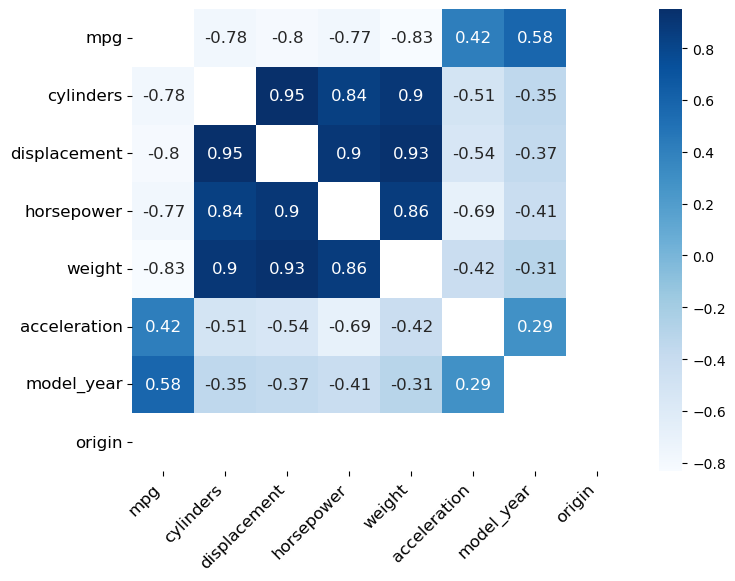

In [201]:
m = np.zeros(df.corr().shape)
diag_indices = np.diag_indices_from(m)
m[diag_indices] = 1
mask = m.astype(bool)

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(),annot=True,annot_kws={'fontsize': 12},cmap='Blues',mask=mask)
plt.xticks(fontsize=12,rotation=45,ha='right')
plt.yticks(fontsize=12)
plt.show()

- The variables which negatively impact fuel efficiency
  - 1) Weight : - 0.86
  - 2) Displacement : -0.83
  - 3) Horsepower : -0.81
- Weight is having highest correlation with mpg

<a id='vif'></a>
### Variance inflation factor

In [205]:
numeric_features = df.select_dtypes(np.number).iloc[:,1:]

In [207]:
vif_numeric = numeric_features.apply(zscore)
vif = {col : variance_inflation_factor(vif_numeric.values,i) for i,
       col in enumerate(vif_numeric.columns)}
vif_df = pd.DataFrame(data=vif.items(),columns=['feature','VIF'])
vif_df

,feature,VIF
0,cylinders,10.586640
1,displacement,19.748191
2,horsepower,9.002825
3,weight,10.522969
4,acceleration,2.553445
5,model_year,1.243536


- From variance inflation factor displacement & weight are having very high multi-collinearity

<a id='full_model'></a>
### `linear regression model with full predictors`

In [211]:
lr = LinearRegression()

In [213]:
cat_variable = ['cylinders','model_year','origin',]
numeric_variable = ['displacement','horsepower','acceleration','weight']

In [215]:
df_categorical = pd.get_dummies(df[cat_variable].astype(str),drop_first=True)
df_numeric = df[numeric_variable]
target = df[['mpg']]
X = pd.concat([df_numeric,df_categorical],axis=1)
y = target
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
lr.fit(X_train,y_train)

LinearRegression()

### calculation of Residual

In [218]:
y_pred = lr.predict(X_train)
Act_pred = pd.DataFrame({'y_actual': y_train.to_numpy().ravel(),'y_predicted': y_pred.ravel()})
Act_pred['Residual'] = Act_pred['y_actual'] - Act_pred['y_predicted']

<a id='after_model'></a>
### `Checking Assumptions of linear Regression`

- Linear relationship between dependent and independent variables
- Independence of observations should exist (i.e. Absence of Autocorrelation)
- The error terms should be homoscedastic
- The error terms must follow normal distribution

### 1) Linear Relationship between dependent and Independent variables

- let us visualize Residuals with every predictor

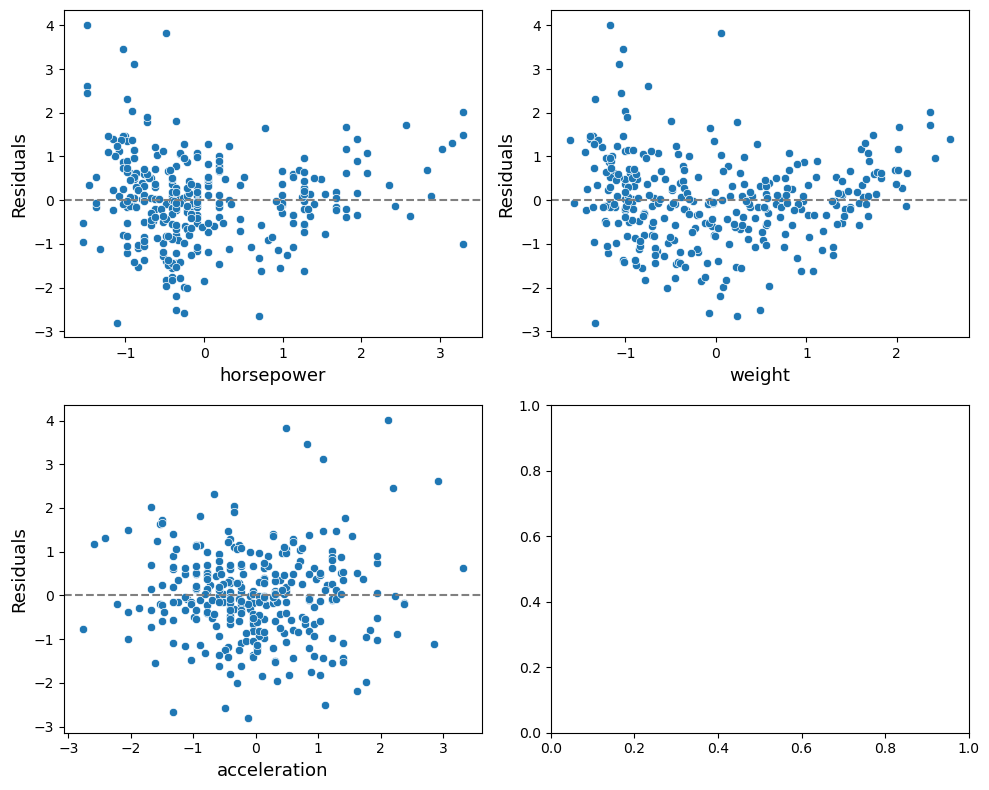

In [223]:
residual = y_train - y_pred
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax = ax.flatten()
for plot,col in enumerate(['horsepower', 'weight','acceleration']):
    sns.scatterplot(y=zscore(residual.to_numpy().ravel()),x=zscore(X_train[col].to_numpy().ravel()),ax=ax[plot])
    ax[plot].set_ylabel("Residuals",fontsize=13)
    ax[plot].axhline(ls='--',color='grey')
    ax[plot].set_xlabel(col,fontsize=13)
plt.tight_layout()
plt.show()

- We are not seeing any patterns,trend within Residual vs predictors plots
- That will confirm & satisfy linear Assumption 

### 2) Autocorrelation of residuals

- **Durbin_watson** Autocorrelation test will confirm the amount of Auto correlation
  - H0 :  The error terms are not autocorrelated 
  - H1 :  The error terms are autocorrelated
- Autocorrelation Range
  - (0-2) - Positive Autocorrelation
  -   2   - No Autocorrelation
  - (2-4) - Negative Autocorrelation
- Acceptable range - (1.5 to 2.5)

In [228]:
from statsmodels.stats.stattools import durbin_watson
test_statistic = durbin_watson(Act_pred['Residual'])

print(f"Durbin watson Test_statistic : {test_statistic:0.4f}")

Durbin watson Test_statistic : 2.0843


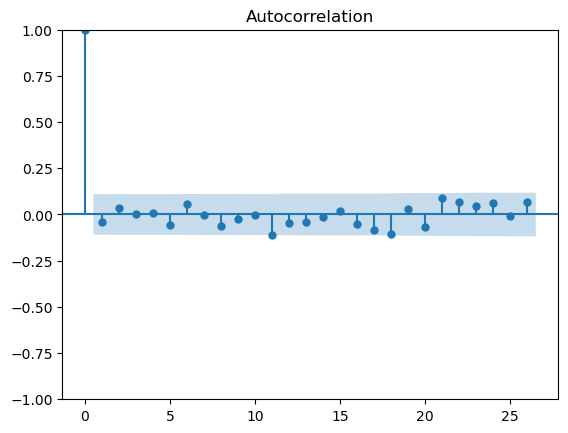

In [230]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Act_pred['Residual'])
plt.show()

- From above plot there no term is crossing confidence interval
- Absolutely no autocorrelation exist

### 3) Homoscedasticity of residuals & Normality of Residuals

The plot of residuals against the fitted values tells whether the residuals have equal variance

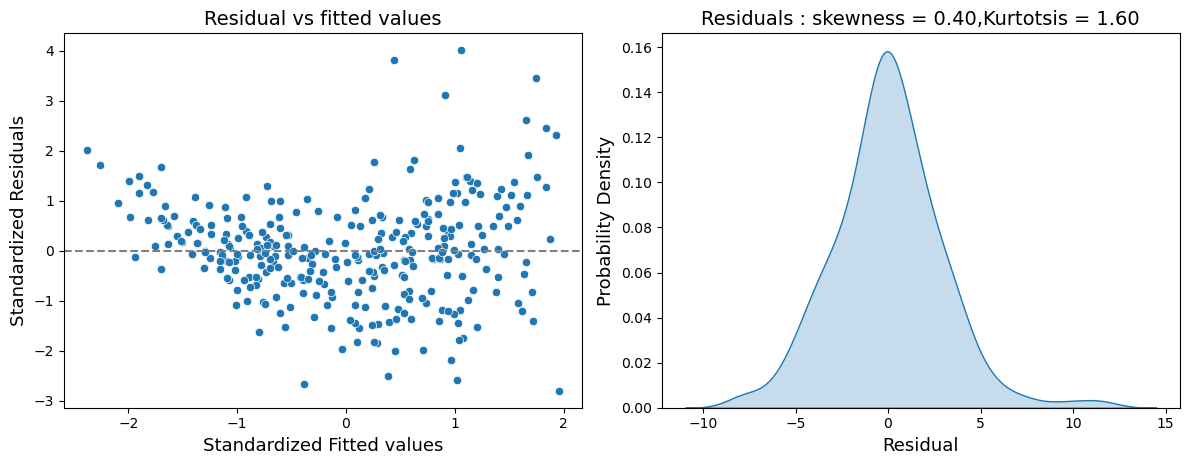

In [235]:
plt.figure(figsize=(12,4.75))
plt.subplot(121)
sns.scatterplot(data=Act_pred.apply(zscore),y='Residual',x='y_predicted')
plt.ylabel("Standardized Residuals",fontsize=13)
plt.xlabel("Standardized Fitted values",fontsize=13)
plt.axhline(ls='--',color='grey')
plt.title("Residual vs fitted values",fontsize=14)

plt.subplot(122)
sns.kdeplot(Act_pred['Residual'],fill=True,palette='viridis')
plt.xlabel("Residual",fontsize=13)
plt.ylabel("Probability Density",fontsize=13)
plt.title(f"Residuals : skewness = {Act_pred['Residual'].skew():0.2f},Kurtotsis = {Act_pred['Residual'].kurt():0.2f}",
         fontsize=14)
plt.tight_layout()
plt.show()

- **from first plot**
    - from first plot there is not trend wheather its linear, non-linear
    - Residuals are Homoscedastic (Equal variance)
    - So Homoscedasticity assumption confirmed
- **from second plot**
    - Residuals are normally distributed

<a id='eval'></a>
### `Model Evaluation`

- **Metrics**
  - Coefficient of Determination
  - Mean absolute Error
  - Root mean squared error
  - Mean absolute percentage Error

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

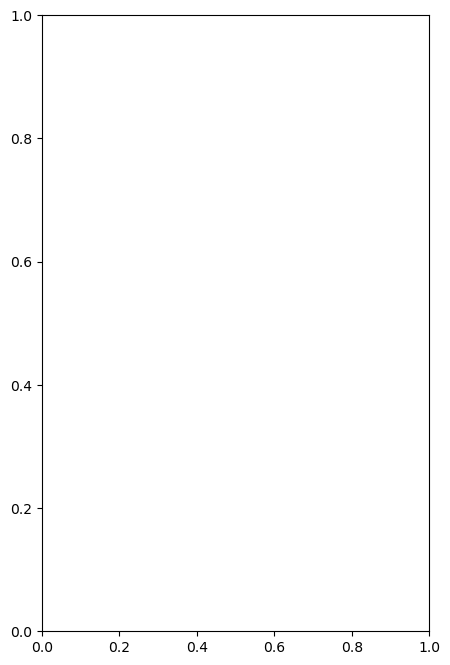

In [240]:
fig,ax = plt.subplots(figsize=(5,8))
ax = sns.barplot(lr.coef_.ravel(),X.columns,orient='h')
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
plt.title("Model coefficients",fontsize=14)
plt.xlabel("Average change in mpg \n for unit change in quantities",fontsize=12)
plt.show()

In [242]:
first = report(lr,X_train, X_test, y_train, y_test)

** LinearRegression Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 86.37 % mpg explained
Adjusted R2 score = 85.45 % mpg explained
Test R2 score 85.77 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.9237 mpg
Test RMSE = 2.7665 mpg
Variance = -0.1572 mpg
--------------------------------------------------
Cross validation RMSE : 3.3748 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 81.17 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 2.1731 mpg
Test MAE = 2.2443 mpg
Variance = 0.0712 mpg
--------------------------------------------------
Mean Absolute Percentage Error
---------------------

AttributeError: 'DataFrame' object has no attribute 'append'

<a id='Interval_estimate'></a>
### `Interval estimate of the model performance`

- Reasons for Interval Estimate of model performance
   - Since Hold-out cross validation will not represent the skill estimatation of model against Real world
   - Since model trained on different samples, tested on completely unseen samples
   - since data points in test phase are not involved while training
   - single performance estimate will not represent the real-world estimate of the performance of the Model
   - Different train,validation split will give different estimates

In [246]:
def interval_estimate(model,X_train,y_train,cv=None,random_state=56,ci=0.95):
    """scoring : Root mean squared Error"""
    scoring = 'neg_root_mean_squared_error'

    score = cross_val_score(model,X_train,y_train,cv=cv,scoring=scoring)
    print(f"mean : {score.mean()*-1:0.4f}, std deviation : {score.std():0.4f}")
    score = -1*score
    ci = ci + (1-ci)/2
    
    Margin_of_error = stats.sem(score) * stats.norm.ppf(ci)  
    upper_limit = score.mean() + Margin_of_error
    lower_limit = score.mean() - Margin_of_error
    conf_interval = f"95% confidence interval RMSE : ({lower_limit:0.4f} , {upper_limit:0.4f})"
    print(conf_interval)
    
    plt.figure(figsize=(6,5))
    sns.histplot(score,kde=True)
    plt.xlabel("Root mean squared Error",fontsize=14)
    plt.ylabel("frequency",fontsize=14)
    plt.axvline(score.mean(),ls='--',c='black')
    plt.title("Cross validation Results",fontsize=14)
    return plt.show()

mean : 3.1435, std deviation : 0.4655
95% confidence interval RMSE : (3.0518 , 3.2352)


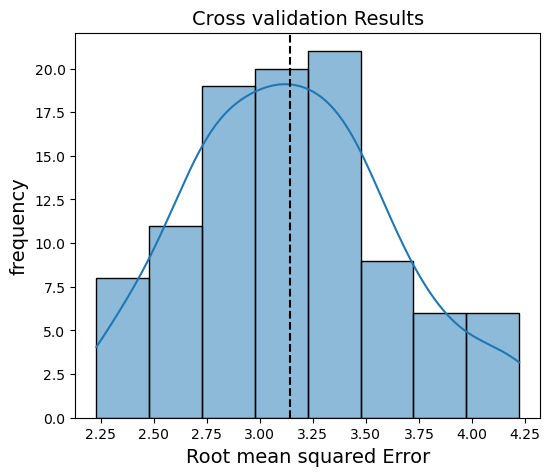

In [248]:
final_regression = LinearRegression()

cv_1 = RepeatedKFold(n_splits=10,n_repeats=10,random_state=56)

interval_estimate(final_regression,X_train,y_train,cv=cv_1)

<a id='Feature_eval'></a>
## `Feature selection & Evaluation`

- According to market standards we have a metric called
   - **power/weight ratio in hp/gallon**
- power/weight ratio is a deciding factor which drives car sales in the market

In [252]:
power_to_weight_ratio = df['horsepower'] / df['weight']

In [254]:
# Checking correlation with variables including Target

df.corrwith(power_to_weight_ratio)

mpg            -0.243536
cylinders       0.246211
displacement    0.283185
horsepower      0.599162
weight          0.130381
acceleration   -0.711414
model_year     -0.336677
origin               NaN
dtype: float64

In [256]:
sns.scatterplot(power_to_weight_ratio,df['mpg'],hue=df['origin'])
plt.xlabel("power/weight ratio",fontsize=12)
plt.ylabel("mpg",fontsize=12)
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

- Power to weight ratio is not having any correlation with **'fuel efficiency'(mpg)**
- Since this is not giving any information
- So we will not consider power/weight into our analysis

- Acceleration is having poor correlation with target
- Displacement is explained by weight

- Let's drop feature **'Displacement'**

In [261]:
categoty = ['cylinders', 'model_year', 'origin']
numerical = ['displacement', 'horsepower','acceleration', 'weight']

list_drop = ['displacement']

model_2 = LinearRegression()

linear_model(model_2,df,droplist=list_drop) 

** LinearRegression Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 86.36 % mpg explained
Adjusted R2 score = 85.49 % mpg explained
Test R2 score 85.86 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.9244 mpg
Test RMSE = 2.7573 mpg
Variance = -0.1670 mpg
--------------------------------------------------
Cross validation RMSE : 3.3600 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 81.32 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 2.1742 mpg
Test MAE = 2.2393 mpg
Variance = 0.0650 mpg
--------------------------------------------------
Mean Absolute Percentage Error
---------------------

AttributeError: 'DataFrame' object has no attribute 'append'

- according to report we are having a bias of RMSE 0.128 miles per gallon
- compared to previous model with full predictors RMSE has slightly decreased
- There is no such significant improvement 

- **Let's drop horsepower & displacement and see our results**

In [277]:
categoty = ['cylinders', 'model_year', 'origin']
numerical = ['displacement','acceleration', 'weight']

list_drop = ['horsepower','displacement']

model_3 = LinearRegression()

linear_model(model_3,df,droplist=list_drop)

** LinearRegression Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 86.17 % mpg explained
Adjusted R2 score = 85.34 % mpg explained
Test R2 score 85.97 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.9444 mpg
Test RMSE = 2.7469 mpg
Variance = -0.1975 mpg
--------------------------------------------------
Cross validation RMSE : 3.3621 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 81.15 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 2.2029 mpg
Test MAE = 2.2228 mpg
Variance = 0.0199 mpg
--------------------------------------------------
Mean Absolute Percentage Error
---------------------

AttributeError: 'DataFrame' object has no attribute 'append'

- **Let's drop acceleration & displacement and see our results**

<a id='final_MLR'></a>
### `Final MLR model`

In [281]:
categoty = ['cylinders', 'model_year', 'origin']
numerical = ['displacement', 'horsepower','acceleration', 'weight']

list_drop = ['displacement']

final_regression_2 = LinearRegression()
linear_model(final_regression_2,df,droplist=list_drop)

** LinearRegression Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 86.36 % mpg explained
Adjusted R2 score = 85.49 % mpg explained
Test R2 score 85.86 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.9244 mpg
Test RMSE = 2.7573 mpg
Variance = -0.1670 mpg
--------------------------------------------------
Cross validation RMSE : 3.3600 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 81.32 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 2.1742 mpg
Test MAE = 2.2393 mpg
Variance = 0.0650 mpg
--------------------------------------------------
Mean Absolute Percentage Error
---------------------

AttributeError: 'DataFrame' object has no attribute 'append'

mean : 3.1435, std deviation : 0.4655
95% confidence interval RMSE : (3.0518 , 3.2352)


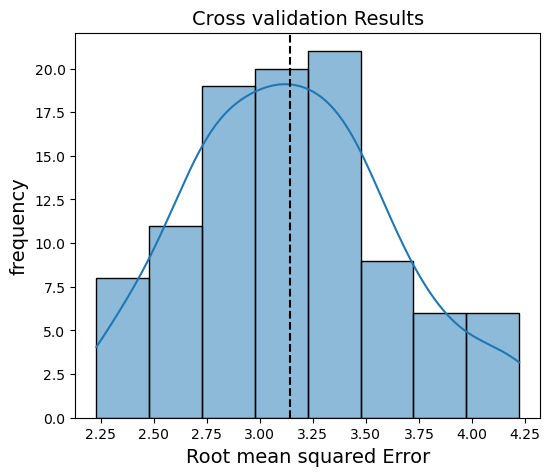

In [282]:
cv_1 = RepeatedKFold(n_splits=10,n_repeats=10,random_state=56)

interval_estimate(final_regression_2,X_train,y_train,cv=cv_1)

- Linear Regression model is expected to perform with the error(RMSE) in the range of 
- (2.6523 , 2.7981) miles per gallon

### Our predictors are explaining 87% of variation in mpg in the model
### Our linear Regression model is expected to predict the mileage with the error of 2.75 miles/gallon (CV RMSE)

In [286]:
Model_reports

,Model_name,Train_R2,Test_R2,CV_R2_score,Train_RMSE,Test_RMSE,CV_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE


<a id='Reg'></a>
## `Regularization`

- let's drop **'displacement'** & apply regularization to Multiple linear regression

### Data pre-processing

In [292]:
cat_variable = ['cylinders','model_year','origin']
numeric_variable = ['weight','horsepower','acceleration']

df_categorical = pd.get_dummies(df[cat_variable].astype(str),drop_first=True)
df_numeric = df[numeric_variable]
X = pd.concat([df_numeric,df_categorical],axis=1)
y = df[['mpg']]

In [294]:
# Standardizing dataset before applying model, for proper application of Regularization

X_std = pd.concat([df_numeric,df_categorical],axis=1).apply(zscore)
y = target

X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.20, random_state=55)

In [296]:
lasso_model = Lasso(random_state=42)

param_grid = {'alpha' : np.linspace(0,5,500)}

<a id='L1_reg'></a>
### `Lasso Regression (L1-regularization)`

- let's drop **'displacement'** & apply L-1 regularization to Multiple linear regression

In [300]:
cv2 = KFold(n_splits=5)
Lasso_grid = GridSearchCV(lasso_model,param_grid=param_grid,cv=cv2,
                          scoring='neg_root_mean_squared_error')
Lasso_grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Lasso(random_state=42),
             param_grid={'alpha': array([0.        , 0.01002004, 0.02004008, 0.03006012, 0.04008016,
       0.0501002 , 0.06012024, 0.07014028, 0.08016032, 0.09018036,
       0.1002004 , 0.11022044, 0.12024048, 0.13026052, 0.14028056,
       0.1503006 , 0.16032064, 0.17034068, 0.18036072, 0.19038076,
       0.2004008 , 0.210...
       4.70941884, 4.71943888, 4.72945892, 4.73947896, 4.749499  ,
       4.75951904, 4.76953908, 4.77955912, 4.78957916, 4.7995992 ,
       4.80961924, 4.81963928, 4.82965932, 4.83967936, 4.8496994 ,
       4.85971944, 4.86973948, 4.87975952, 4.88977956, 4.8997996 ,
       4.90981964, 4.91983968, 4.92985972, 4.93987976, 4.9498998 ,
       4.95991984, 4.96993988, 4.97995992, 4.98997996, 5.        ])},
             scoring='neg_root_mean_squared_error')

In [301]:
Lasso_grid.best_estimator_.get_params()['alpha']

0.01002004008016032

In [302]:
tuned_lasso = Lasso(Lasso_grid.best_params_['alpha'])
tuned_lasso.fit(X_train,y_train)

Lasso(alpha=0.01002004008016032)

In [306]:
report(tuned_lasso,X_train,X_test,y_train,y_test)

** Lasso Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 85.80 % mpg explained
Adjusted R2 score = 84.90 % mpg explained
Test R2 score 87.70 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.8978 mpg
Test RMSE = 2.8773 mpg
Variance = -0.0205 mpg
--------------------------------------------------
Cross validation RMSE : 3.1802 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 82.68 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 2.1332 mpg
Test MAE = 2.4005 mpg
Variance = 0.2674 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------

AttributeError: 'DataFrame' object has no attribute 'append'

- slightly improvement in all the scores & generalization compared to Multiple linear Regression

mean : 2.6947, std deviation : 0.3181
95% confidence interval RMSE : (2.6320 , 2.7573)


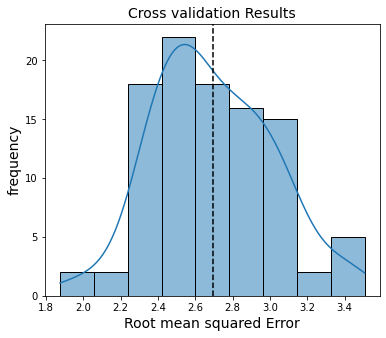

In [1676]:
cv_1 = RepeatedKFold(n_splits=10,n_repeats=10,random_state=56)

interval_estimate(tuned_lasso,X_train,y_train,cv=cv_1)

- So with L-1 Regularization we have slightly better generalization compared to OLS

<a id='L2_reg'></a>
### `Ridge Regression (L2-regularization)`

- let's drop **'displacement'** & apply regularization to Multiple linear regression

In [1677]:
cat_variable = ['cylinders','model_year','origin']
numeric_variable = ['weight','horsepower','displacement','acceleration']

df_categorical = pd.get_dummies(df[cat_variable].astype(str),drop_first=True)
df_numeric = df[numeric_variable]
X = pd.concat([df_numeric,df_categorical],axis=1)
y = df[['mpg']]

In [1678]:
# Standardizing dataset before applying model, for proper application of Regularization

X_std = pd.concat([df_numeric,df_categorical],axis=1).apply(zscore)
y = target

X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.20, random_state=55)

In [1679]:
Ridge_model = Ridge(random_state=42)

param_grid = {'alpha' : np.linspace(0,5,500)}

In [1680]:
Ridge_Grid = GridSearchCV(Ridge_model,param_grid=param_grid,cv=cv2,
                         scoring='neg_root_mean_squared_error')
Ridge_Grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Ridge(random_state=42),
             param_grid={'alpha': array([0.        , 0.01002004, 0.02004008, 0.03006012, 0.04008016,
       0.0501002 , 0.06012024, 0.07014028, 0.08016032, 0.09018036,
       0.1002004 , 0.11022044, 0.12024048, 0.13026052, 0.14028056,
       0.1503006 , 0.16032064, 0.17034068, 0.18036072, 0.19038076,
       0.2004008 , 0.210...
       4.70941884, 4.71943888, 4.72945892, 4.73947896, 4.749499  ,
       4.75951904, 4.76953908, 4.77955912, 4.78957916, 4.7995992 ,
       4.80961924, 4.81963928, 4.82965932, 4.83967936, 4.8496994 ,
       4.85971944, 4.86973948, 4.87975952, 4.88977956, 4.8997996 ,
       4.90981964, 4.91983968, 4.92985972, 4.93987976, 4.9498998 ,
       4.95991984, 4.96993988, 4.97995992, 4.98997996, 5.        ])},
             scoring='neg_root_mean_squared_error')

In [1681]:
Ridge_Grid.best_params_

{'alpha': 2.024048096192385}

In [1682]:
tuned_ridge = Ridge(Ridge_Grid.best_params_['alpha'])
tuned_ridge.fit(X_train,y_train)

Ridge(alpha=2.024048096192385)

In [1683]:
report(tuned_ridge,X_train,X_test,y_train,y_test)

** Ridge Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 86.70 % mpg explained
Adjusted R2 score = 85.73 % mpg explained
Test R2 score 86.39 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.5106 mpg
Test RMSE = 2.5036 mpg
Variance = -0.0070 mpg
--------------------------------------------------
Cross validation RMSE : 2.7146 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 84.06 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.9601 mpg
Test MAE = 1.7506 mpg
Variance = -0.2094 mpg
--------------------------------------------------
Mean Absolute Percentage Error
-------------------------------

In [1684]:
cv_tuned_ridge = cross_val_score(tuned_ridge,X_train,y_train,scoring='neg_mean_absolute_error').mean()*-1

In [1685]:
print(f"Cross validation RMSE of Ridge regression - {cv_tuned_ridge:0.4f}")

Cross validation RMSE of Ridge regression - 2.1786


mean : 2.7058, std deviation : 0.3109
95% confidence interval RMSE : (2.6446 , 2.7671)


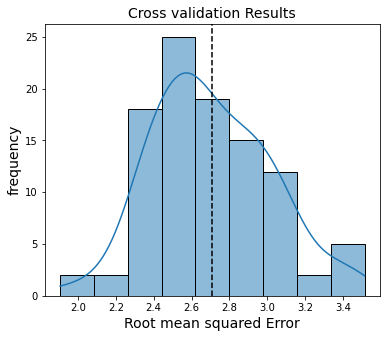

In [1686]:
cv_2 = RepeatedKFold(n_splits=10,n_repeats=10,random_state=56)
model_ridge = Ridge(alpha=Ridge_Grid.best_params_['alpha'])
              
interval_estimate(tuned_ridge,X_train,y_train,cv=cv_2)

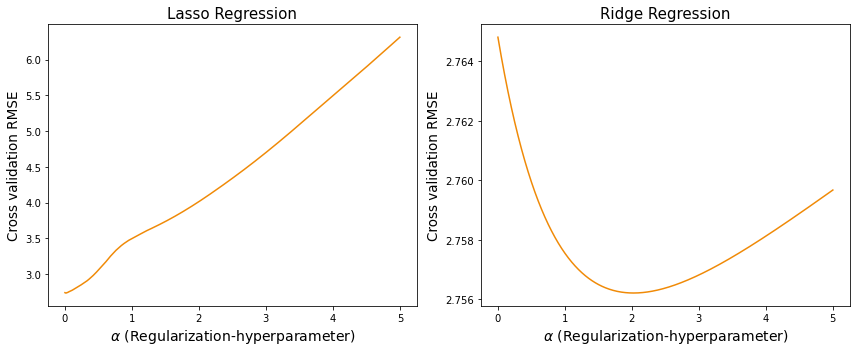

In [1687]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
for plot,model in enumerate([Lasso_grid,Ridge_Grid]):
    sns.lineplot(np.linspace(0,5,500),(model.cv_results_['mean_test_score']*-1),color='#F08A07',ax=ax[plot])
    ax[plot].set_xlabel(r'$\alpha$ (Regularization-hyperparameter)',fontsize=14)
    ax[plot].set_ylabel("Cross validation RMSE",fontsize=13.5)
    ax[plot].set_title("Lasso Regression",fontsize=15) if plot == 0 else ax[plot].set_title("Ridge Regression",fontsize=15)
plt.tight_layout()
plt.show()

<a id='poly_reg'></a>
## `Polynomial linear Regression`

In [1688]:
df.select_dtypes(np.number).columns

Index(['mpg', 'displacement', 'horsepower', 'weight', 'acceleration'], dtype='object')

In [1689]:
cat_variable = ['cylinders','model_year','origin']
numeric_variable = ['horsepower', 'weight', 'acceleration']

df_categorical = pd.get_dummies(df[cat_variable].astype(str),drop_first=True)
df_numeric = df[numeric_variable]
X = df_numeric
y = df[['mpg']]

In [1690]:
poly = PolynomialFeatures(degree=2,include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names(X.columns))

In [1691]:
X_poly.shape

(405, 9)

In [1692]:
# Standardizing dataset before applying model, for proper application of Regularization

X_std = pd.concat([X_poly,df_categorical],axis=1).apply(zscore) 

In [1693]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_std,y,test_size=0.20,random_state=42)

In [1694]:
lr_poly = LinearRegression()

In [1695]:
Xp_train.shape

(324, 27)

In [1696]:
Xp_test.shape

(81, 27)

In [1697]:
train_rmse,test_rmse,cv_rmse_poly = list(),list(),list()

for degree in range(2,8):
    poly = PolynomialFeatures(degree=degree,include_bias=False)
    X_poly = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names(X.columns))
    X_std1 = pd.concat([X_poly,df_categorical],axis=1).apply(zscore)
    y = df[['mpg']]
    Xp1_train, Xp1_test, yp1_train, yp1_test = train_test_split(X_std1,y,test_size=0.20,random_state=42)
    lr1_poly = LinearRegression()
    lr1_poly.fit(Xp1_train,yp1_train)
    train_rmse.append(mean_squared_error(yp1_train,lr1_poly.predict(Xp1_train),squared=False))
    test_rmse.append(mean_squared_error(yp1_test,lr1_poly.predict(Xp1_test),squared=False))
    cv_p = KFold(n_splits=5,shuffle=True, random_state=55)
    cv_poly = cross_val_score(lr1_poly,Xp1_train,yp1_train,cv=cv_p).mean()
    cv_rmse_poly.append(cv_poly)

In [1698]:
lr_poly.fit(Xp_train,yp_train)

LinearRegression()

In [1699]:
mean_squared_error(yp_test,lr_poly.predict(Xp_test),squared=False)

2.330663574701155

In [1700]:
report(lr_poly,Xp_train, Xp_test, yp_train, yp_test)

** LinearRegression Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 87.84 % mpg explained
Adjusted R2 score = 86.73 % mpg explained
Test R2 score 88.52 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.3962 mpg
Test RMSE = 2.3307 mpg
Variance = -0.0655 mpg
--------------------------------------------------
Cross validation RMSE : 2.6843 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 84.24 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.8559 mpg
Test MAE = 1.7578 mpg
Variance = -0.0981 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------

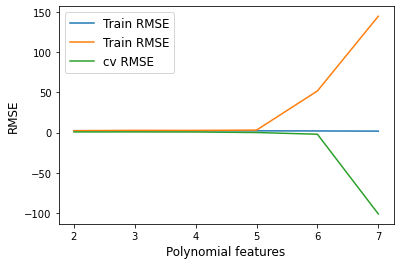

In [1701]:
sns.lineplot(range(2,8),train_rmse,label='Train RMSE')
sns.lineplot(range(2,8),test_rmse,label='Train RMSE')
sns.lineplot(range(2,8),cv_rmse_poly,label='cv RMSE')
plt.xlabel("Polynomial features",fontsize=12)
plt.ylabel("RMSE",fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [1702]:
Model_reports

,Model_name,Train_R2,Test_R2,CV_R2_score,Train_RMSE,Test_RMSE,CV_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
0,LinearRegression,86.65%,87.55%,83.19,2.5109,2.4269,2.7813,1.9452,1.7779,8.76%,8.89%
1,LinearRegression,86.48%,88.03%,83.38,2.5268,2.3803,2.7559,1.9573,1.7422,8.82%,8.62%
2,LinearRegression,86.13%,87.42%,82.97,2.5592,2.4402,2.7897,2.0109,1.7979,9.09%,8.96%
3,Lasso,86.67%,86.2%,84.24,2.514,2.5204,2.6976,1.9603,1.7692,8.95%,8.31%
4,Ridge,86.7%,86.39%,84.06,2.5106,2.5036,2.7146,1.9601,1.7506,8.95%,8.2%
5,LinearRegression,87.84%,88.52%,84.24,2.3962,2.3307,2.6843,1.8559,1.7578,8.22%,8.85%


## `Regularization of Polynomial linear Regression`

<a id='poly_L1_reg'></a>
### `1) Polynomial linear regression with L1 - regularization`

In [1703]:
poly_lasso = Lasso(random_state=42)

In [1704]:
param_poly_lasso = {'alpha': np.linspace(0,5,500)}
cv_poly_lasso = KFold(n_splits=5,shuffle=True,random_state=42)

In [1705]:
poly_lasso_grid= GridSearchCV(poly_lasso,param_grid=param_poly_lasso,cv=cv_poly_lasso)

poly_lasso_grid.fit(Xp_train,yp_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(random_state=42),
             param_grid={'alpha': array([0.        , 0.01002004, 0.02004008, 0.03006012, 0.04008016,
       0.0501002 , 0.06012024, 0.07014028, 0.08016032, 0.09018036,
       0.1002004 , 0.11022044, 0.12024048, 0.13026052, 0.14028056,
       0.1503006 , 0.16032064, 0.17034068, 0.18036072, 0.19038076,
       0.2004008 , 0.210420...
       4.65931864, 4.66933868, 4.67935872, 4.68937876, 4.6993988 ,
       4.70941884, 4.71943888, 4.72945892, 4.73947896, 4.749499  ,
       4.75951904, 4.76953908, 4.77955912, 4.78957916, 4.7995992 ,
       4.80961924, 4.81963928, 4.82965932, 4.83967936, 4.8496994 ,
       4.85971944, 4.86973948, 4.87975952, 4.88977956, 4.8997996 ,
       4.90981964, 4.91983968, 4.92985972, 4.93987976, 4.9498998 ,
       4.95991984, 4.96993988, 4.97995992, 4.98997996, 5.        ])})

In [1706]:
poly_lasso_grid.best_params_

{'alpha': 0.0}

In [1707]:
tuned_poly_lasso = Lasso(poly_lasso_grid.best_params_['alpha'])
tuned_poly_lasso.fit(Xp_train,yp_train)

Lasso(alpha=0.0)

In [1708]:
report(tuned_poly_lasso,Xp_train, Xp_test, yp_train, yp_test)

** Lasso Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 87.71 % mpg explained
Adjusted R2 score = 86.59 % mpg explained
Test R2 score 88.13 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.4089 mpg
Test RMSE = 2.3704 mpg
Variance = -0.0385 mpg
--------------------------------------------------
Cross validation RMSE : 2.6600 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 84.45 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.8595 mpg
Test MAE = 1.8076 mpg
Variance = -0.0519 mpg
--------------------------------------------------
Mean Absolute Percentage Error
-------------------------------

<a id='poly_L2_reg'></a>
### `2) Polynomial linear regression with L2 - regularization`

In [1709]:
poly_ridge = Ridge()

In [1710]:
param_poly_ridge = {'alpha': np.linspace(0,5,500)}
cv_poly_ridge = KFold(n_splits=5,shuffle=True,random_state=42)

In [1711]:
poly_ridge_grid= GridSearchCV(poly_ridge,param_grid=param_poly_ridge,cv=cv_poly_ridge)

poly_ridge_grid.fit(Xp_train,yp_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': array([0.        , 0.01002004, 0.02004008, 0.03006012, 0.04008016,
       0.0501002 , 0.06012024, 0.07014028, 0.08016032, 0.09018036,
       0.1002004 , 0.11022044, 0.12024048, 0.13026052, 0.14028056,
       0.1503006 , 0.16032064, 0.17034068, 0.18036072, 0.19038076,
       0.2004008 , 0.21042084, 0.22044088, 0...
       4.65931864, 4.66933868, 4.67935872, 4.68937876, 4.6993988 ,
       4.70941884, 4.71943888, 4.72945892, 4.73947896, 4.749499  ,
       4.75951904, 4.76953908, 4.77955912, 4.78957916, 4.7995992 ,
       4.80961924, 4.81963928, 4.82965932, 4.83967936, 4.8496994 ,
       4.85971944, 4.86973948, 4.87975952, 4.88977956, 4.8997996 ,
       4.90981964, 4.91983968, 4.92985972, 4.93987976, 4.9498998 ,
       4.95991984, 4.96993988, 4.97995992, 4.98997996, 5.        ])})

In [1712]:
poly_ridge_grid.best_params_['alpha']

0.02004008016032064

In [1713]:
tuned_poly_ridge = Ridge(poly_ridge_grid.best_params_['alpha'])
tuned_poly_ridge.fit(Xp_train,yp_train)

Ridge(alpha=0.02004008016032064)

In [1714]:
report(tuned_poly_ridge,Xp_train, Xp_test, yp_train, yp_test)

** Ridge Evaluation & Report **
--------------------------------------------------
R2 and Adjusted R2 score
--------------------------------------------------
Train R2 score = 87.84 % mpg explained
Adjusted R2 score = 86.73 % mpg explained
Test R2 score 88.57 % mpg explained
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.3967 mpg
Test RMSE = 2.3259 mpg
Variance = -0.0708 mpg
--------------------------------------------------
Cross validation RMSE : 2.6720 mpg
--------------------------------------------------
--------------------------------------------------
Cross validation R2_score : 84.36 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.8554 mpg
Test MAE = 1.7593 mpg
Variance = -0.0961 mpg
--------------------------------------------------
Mean Absolute Percentage Error
-------------------------------

In [1715]:
Model_reports

,Model_name,Train_R2,Test_R2,CV_R2_score,Train_RMSE,Test_RMSE,CV_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
0,LinearRegression,86.65%,87.55%,83.19,2.5109,2.4269,2.7813,1.9452,1.7779,8.76%,8.89%
1,LinearRegression,86.48%,88.03%,83.38,2.5268,2.3803,2.7559,1.9573,1.7422,8.82%,8.62%
2,LinearRegression,86.13%,87.42%,82.97,2.5592,2.4402,2.7897,2.0109,1.7979,9.09%,8.96%
3,Lasso,86.67%,86.2%,84.24,2.514,2.5204,2.6976,1.9603,1.7692,8.95%,8.31%
4,Ridge,86.7%,86.39%,84.06,2.5106,2.5036,2.7146,1.9601,1.7506,8.95%,8.2%
5,LinearRegression,87.84%,88.52%,84.24,2.3962,2.3307,2.6843,1.8559,1.7578,8.22%,8.85%
6,Lasso,87.71%,88.13%,84.45,2.4089,2.3704,2.66,1.8595,1.8076,8.21%,9.08%
7,Ridge,87.84%,88.57%,84.36,2.3967,2.3259,2.672,1.8554,1.7593,8.22%,8.84%


<a id='knn'></a>
# `3) K-Nearest-Neighbours`

### Data Preprocessing

In [1716]:
df_knn = data_preprocess.copy()

In [1717]:
df_knn = df_knn.drop(columns=['car_name'])
df_knn['cylinders'] = df_knn['cylinders'].astype(object)

In [1718]:
encode = LabelEncoder()

for i in ['model_year', 'origin']:
    df_knn[i] = encode.fit_transform(df_knn[i])
    if df_knn[i].dtype == object:
        df_knn[i] = df_knn[i].astype(np.int64)
df_knn['cylinders'] = df_knn['cylinders'].astype(np.number)

In [1719]:
X = df_knn.iloc[:,1:].apply(zscore)
y = df_knn.iloc[:,[0]]

In [1720]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=58)

In [1721]:
Knn = KNeighborsRegressor(n_neighbors=5)

In [1722]:
Knn.fit(X_train,y_train)

KNeighborsRegressor()

In [1723]:
report(Knn,X_train,X_test,y_train,y_test)

** KNeighborsRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.0848 mpg
Test RMSE = 3.0450 mpg
Variance = 0.9602 mpg
--------------------------------------------------
Cross validation RMSE : 2.5788 mpg
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.5198 mpg
Test MAE = 2.1297 mpg
Variance = 0.6099 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 6.94 % 
Test MAPE = 9.22 % 
Variance = 2.28 %


<a id='knn-hyper-tuning'></a>
### Tuning hyperparameters of KNN using GridsearchCV

In [1724]:
cv_knn = KFold(n_splits=5,shuffle=True,random_state=45)
param_grid = {'n_neighbors': range(3,25),
              'weights' : ['uniform', 'distance'],
             'p' : [1,2]}

knn_grid = GridSearchCV(Knn,param_grid=param_grid,cv=cv_knn,scoring='neg_mean_squared_error')

In [1725]:
knn_grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(3, 25), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [1726]:
knn_grid.best_estimator_

KNeighborsRegressor(n_neighbors=4, p=1, weights='distance')

In [1727]:
train_knn = []
test_knn = []
cv_knn_rmse = []
for i in range(1,40):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    cv_knn = KFold(n_splits=5,shuffle=True,random_state=45)
    cv_score = cross_val_score(knn,X_train,y_train,scoring='neg_root_mean_squared_error').mean()*-1
    cv_knn_rmse.append(cv_score)
    train_knn.append(mean_squared_error(y_train,knn.predict(X_train),squared=False))
    test_knn.append(mean_squared_error(y_test,knn.predict(X_test),squared=False))

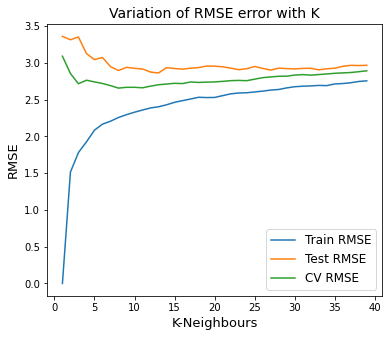

In [1728]:
plt.figure(figsize=(6,5))
plt.plot(range(1,40),train_knn,label='Train RMSE')
plt.plot(range(1,40),test_knn,label='Test RMSE')
plt.plot(range(1,40),cv_knn_rmse,label='CV RMSE')
plt.xlabel("K-Neighbours",fontsize=13)
plt.ylabel("RMSE",fontsize=13)
plt.legend(fontsize=12)
plt.title("Variation of RMSE error with K",fontsize=14)
plt.show()

In [1729]:
knn_grid.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [1730]:
tuned_knn = KNeighborsRegressor(n_neighbors=30)
tuned_knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=30)

- from above graph it seems Train & Test errors are not converging
- There exists a constant variance after Kneighbourhood of 10

In [1731]:
report(tuned_knn,X_train, X_test, y_train, y_test)

** KNeighborsRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.6756 mpg
Test RMSE = 2.9172 mpg
Variance = 0.2416 mpg
--------------------------------------------------
Cross validation RMSE : 2.8089 mpg
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.9828 mpg
Test MAE = 2.1518 mpg
Variance = 0.1690 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 9.12 % 
Test MAPE = 9.36 % 
Variance = 0.24 %


- From above reports we can say, there is significant variance in all Metrics
- So K-Nearest-Neighbours is giving unstable solutions

<a id='report'></a>
## `Report`

In [1761]:
Model_reports.style.highlight_max(1)

,Model_name,Train_R2,Test_R2,CV_R2_score,Train_RMSE,Test_RMSE,CV_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
0,LinearRegression,86.65%,87.55%,83.19,2.510900,2.426900,2.781300,1.945200,1.777900,8.76%,8.89%
1,LinearRegression,86.48%,88.03%,83.38,2.526800,2.380300,2.755900,1.957300,1.742200,8.82%,8.62%
2,LinearRegression,86.13%,87.42%,82.97,2.559200,2.440200,2.789700,2.010900,1.797900,9.09%,8.96%
3,Lasso,86.67%,86.2%,84.24,2.514000,2.520400,2.697600,1.960300,1.769200,8.95%,8.31%
4,Ridge,86.7%,86.39%,84.06,2.510600,2.503600,2.714600,1.960100,1.750600,8.95%,8.2%
5,LinearRegression,87.84%,88.52%,84.24,2.396200,2.330700,2.684300,1.855900,1.757800,8.22%,8.85%
6,Lasso,87.71%,88.13%,84.45,2.408900,2.370400,2.660000,1.859500,1.807600,8.21%,9.08%
7,Ridge,87.84%,88.57%,84.36,2.396700,2.325900,2.672000,1.855400,1.759300,8.22%,8.84%
8,KNeighborsRegressor,nan,nan,nan,2.084800,3.045000,2.578800,1.519800,2.129700,6.94%,9.22%
9,KNeighborsRegressor,nan,nan,nan,2.675600,2.917200,2.808900,1.982800,2.151800,9.12%,9.36%


<a id='final'></a>
## `Final Model` - `Multiple linear Regression`

In [1735]:
categoty = ['cylinders', 'model_year', 'origin']
numerical = ['horsepower','acceleration', 'weight']

df_categorical = pd.get_dummies(df[cat_variable].astype(str),drop_first=True)
df_numeric = df[numeric_variable]
target = df[['mpg']]
X = pd.concat([df_numeric,df_categorical],axis=1)
y = target

Xfinal_train, Xfinal_test, yfinal_train, yfinal_test = train_test_split(X,y,test_size=0.2, random_state=42)

MLR_regression = LinearRegression()
MLR_regression.fit(Xfinal_train,yfinal_train)

LinearRegression()

In [1737]:
import pickle
with open('final_model.pickle','wb') as file:
    pickle.dump(MLR_regression,file)